In [2]:
# Importieren der benötigten Libraries
import numpy as np
import sklearn
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_validate
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


# Aufgabe 4.2 Entscheidungsbäume für Klassifikation


[sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) ist eine Klasse, die eine Mehrklassenklassifizierung eines Datensatzes durchführen kann.

Wie bei anderen Klassifikatoren nimmt _DecisionTreeClassifier_ zwei Arrays während des Trainings als Eingabe entgegen: ein Array _X_, _sparse_ oder _non-sparse_, mit der Größe _[n\_samples, n\_features]_, das die Trainingsproben enthält, und ein Array _Y_ mit ganzzahligen Werten, mit der Größe _[n\_samples]_, das die Klassenbezeichnungen für die Trainingsproben enthält.


In [3]:
# Load and investigate the iris dataset
iris = load_iris()
X = iris.data
y = iris.target
print(X.shape, y.shape)

(150, 4) (150,)


In [14]:
iris.feature_names, iris.target_names

(['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'],
 array(['setosa', 'versicolor', 'virginica'], dtype='<U10'))

In [4]:
# Fit a Decision tree on the iris data
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X, y)

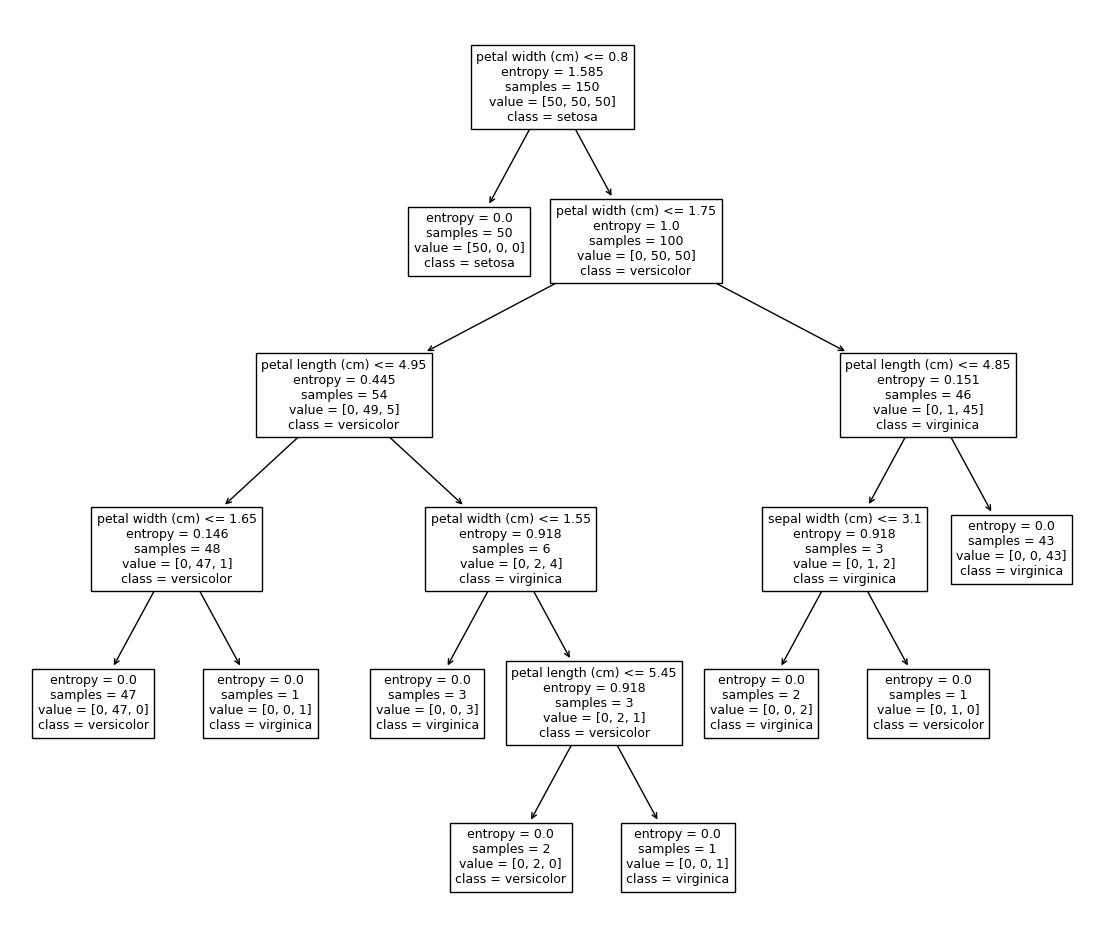

In [5]:
# plot the tree for investigation
plt.figure(figsize=(14,12))
_ = sklearn.tree.plot_tree(clf, fontsize=9, feature_names=iris.feature_names, class_names=iris.target_names)

## a) Unsichere Vorhersagen

Entscheidungsbäume erlauben es eine (Pseudo)-Wahrscheinlichkeit für die Entscheidungen anzugeben.
Finden Sie alle Entscheidungen des Modells für den Testdatensatz, für welches das Modell keine 100\,\% Zuordnung treffen konnte.
Verwenden Sie dabei die Methode _clf.predict\_proba_.

Wir verwenden hierzu den bekannten [Iris](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html)-Datensatz. Ziel ist die Klassifizierung von Untergruppen der [Schwertlilie](https://de.wikipedia.org/wiki/Schwertlilien) (Iris) anhand der Merkmale _petal_ (Blütenblatt) und _sepal_ (Kelchblatt) Länge.

In [36]:
# Train another model with a train-test split and a max depth of 3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
max_depth = 3
clf_1 = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
clf_1.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

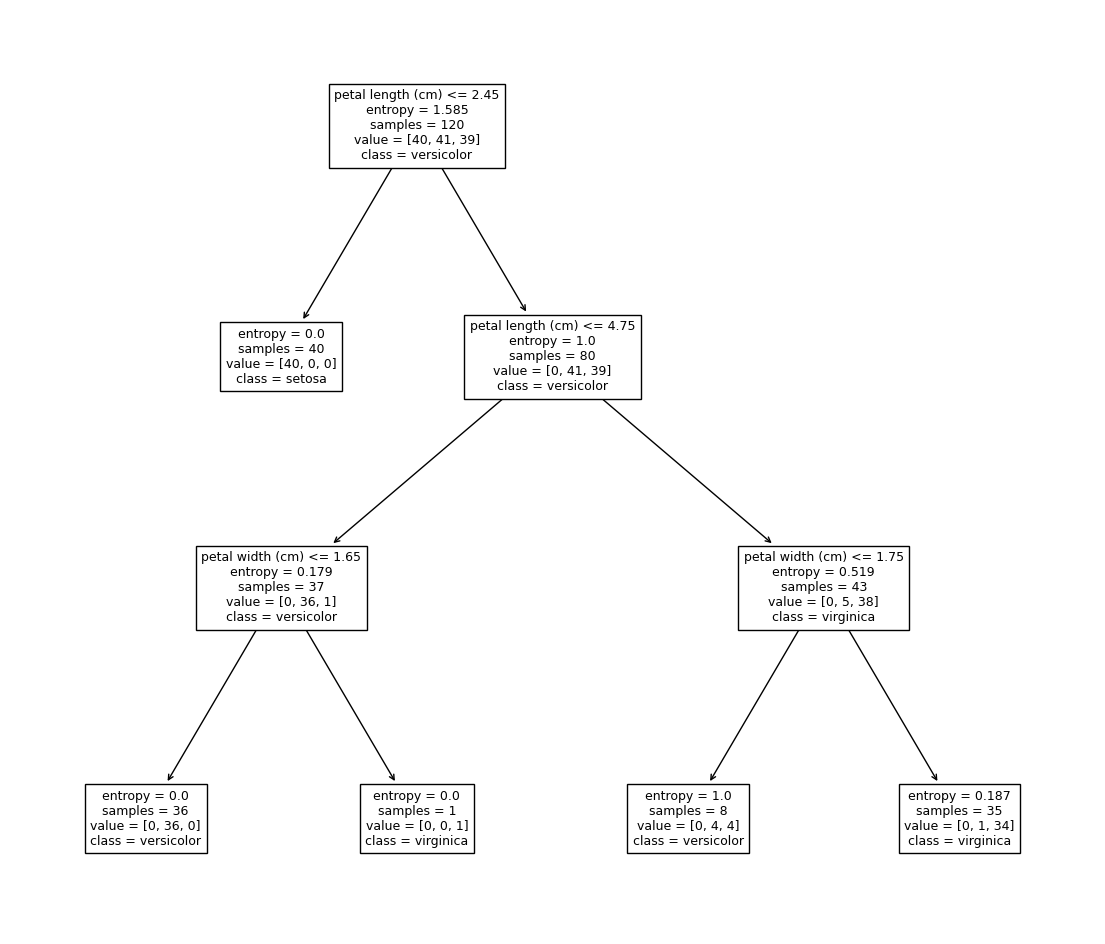

In [38]:
# Plot the new tree for investigation
plt.figure(figsize=(14,12))
_ = sklearn.tree.plot_tree(clf_1, fontsize=9, feature_names=iris.feature_names, class_names=iris.target_names)

In [39]:
"""Computes a boolean array where all items with a probability != 1 are marked as true"""
def get_unsure_instances(clf, X_test) -> np.ndarray:
    probabilities = clf.predict_proba(X_test)
    max_values_each_elem = probabilities.max(axis=1)

    return max_values_each_elem != 1

get_unsure_instances(clf=clf_1, X_test=X_test)

array([False, False,  True, False,  True, False, False,  True, False,
       False,  True, False, False, False, False, False,  True, False,
       False,  True, False,  True, False,  True,  True,  True,  True,
        True, False, False])

## b) Entscheidungsregionen

Um die Entscheidungsregionen zu visualisieren, können wir eine Vorhersage für jeden möglichen Datenpunkt um die gültige Region um den Iris-Datensatz machen. Zur Erleichterung der Visualisierung verwenden wir nun nur noch die ersten 2 Features des Iris-Datensatzes für das Training.

Visualisieren Sie die Entscheidungsregionen des trainierten Modells dar. Sie können hierzu [sklearn.inspection.DecisionBoundaryDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html#sklearn.inspection.DecisionBoundaryDisplay.from_estimator) verwenden. Unterscheiden Sie dabei visuell die Trainings- und Testmenge

In [40]:
# Train decision tree
clf = tree.DecisionTreeClassifier(max_depth=3)
X = iris.data[:, :2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
clf = clf.fit(X_train, y_train)

In [48]:
# Plot the decision boundaries
def plot_decision_boundaries(X_train, y_train, X_test, y_test) -> None:

    f1, f2 = np.meshgrid(
        np.linspace(X_train[:, 0].min(), X_train[:, 0].max()),
        np.linspace(X_train[:, 1].min(), X_train[:, 1].max())
    )
    grid = np.vstack([f1.ravel(), f2.ravel()]).T

    y_pred = np.reshape(clf.predict(grid), f1.shape)

    display = DecisionBoundaryDisplay(
        xx0=f1, 
        xx1=f2,
        response=y_pred
    )

    display.plot()

    display.ax_.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolor="black")

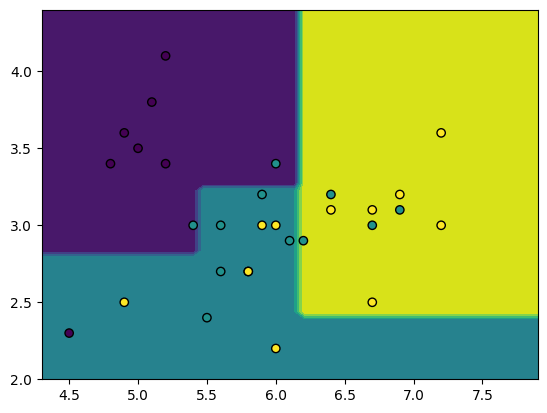

In [49]:
plot_decision_boundaries(X_train, y_train, X_test, y_test)

## c) Kreuzvalidierung

Wir können visuell erkennen, dass der Entscheidungsbaum mit zunehmender Tiefe dazu neigt, sich zu spezialisieren, um zu den einzelnen Datenpunkten zu passen, was zu komplexeren Entscheidungsregionen führt.
Um den optimalen Wert für die maximale Tiefe zu finden, können wir außerdem eine Kreuzvalidierung des 2D-Iris-Datensatzes über einen Bereich möglicher Werte für den Parameter für die maximale Tiefe durchführen.

Implementieren Sie die Methode _get\_acc\_per\_depth_, welche eine 10-fache Kreuzvalidierung durchführt und die korrespondierenden Train- und Testgenauigkeiten zurückgibt.


In [76]:
def cross_val(X, y, max_depth, cv=10):
    clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
    scores = cross_validate(estimator=clf,
                            X=X,
                            y=y,
                            cv=cv,
                            return_train_score=True)
    return np.mean(scores["train_score"]), np.mean(scores["test_score"])


def get_acc_per_max_depth(X: np.ndarray, y: np.ndarray, max_depths: range) -> list[np.ndarray, np.ndarray]:
    """Runs 10-fold cross validation for all given depths and
     returns an array for the corresponding train and test accuracy"""
    acc = np.array([cross_val(X, y, depth) for depth in max_depths])
    train_acc = acc[:, 0]
    test_acc = acc[:, 1]
    return train_acc, test_acc 
    

In [77]:
def plot_results(acc_test, acc_train, depths_to_eval):
    # Plot results
    plt.figure()
    plt.scatter(depths_to_eval, acc_test, label="Accuracy Test", marker="^")
    plt.scatter(depths_to_eval, acc_train, label="Accuracy Train", marker="x")
    plt.legend()
    plt.xlabel("Maximum Tree Depth")
    plt.ylabel("Accuracy")
    plt.title("Decision Tree: Accuracy vs. Max. Depth")
    plt.show()

In [78]:
acc_train, acc_test = get_acc_per_max_depth(iris.data, iris.target, range(1,16))

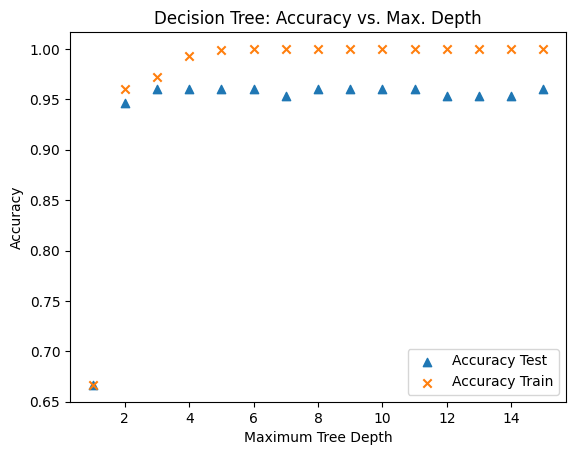

In [81]:
plot_results(acc_test, acc_train, range(1,16) )

# Aufgabe 4.3 Entscheidungsbäume für Regression

Entscheidungsbäume können auch zur Regression verwendet werden.
Dazu erstellen wir eine verrauschte Sinusfunktion.
Wir können jetzt Entscheidungsbäume anpassen, um die Sinusfunktion zu erlernen. Als Ergebnis werden lokale lineare Regressionen gelernt, die sich der Sinuskurve annähern.

In [82]:
def distorted_sin():
    # Create a random dataset
    X_cont = np.sort(10 * np.random.rand(80, 1), axis=0)
    y_cont = np.sin(X_cont).ravel()
    y_cont += 0.5 * (0.5 - np.random.rand(80))
    y_cont[::5] += 3 * (0.5 - np.random.rand(16))
    return X_cont, y_cont

In [83]:
# create dataset
X, y = distorted_sin()

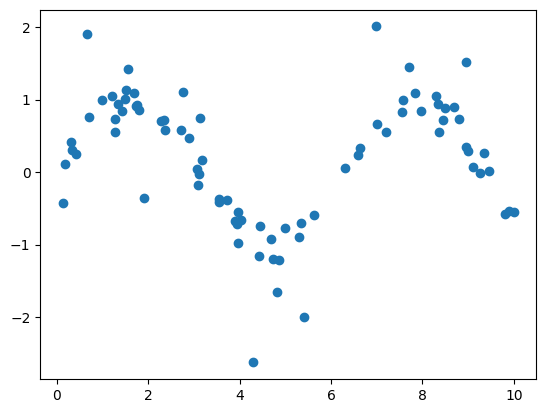

In [84]:
# plot the training data
plt.scatter(X, y)

## a) Regression

Verwenden Sie den [sklearn.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) in der Methode _get\_dt\_prediction_ um eine Regression mittels eines Entscheidungsbaum anzuwenden. Geben Sie anschließend die Vorhersagen des Modells für gegebenen Trainingdatensatz zurück.


In [85]:
def get_dt_prediction(X_train: np.ndarray, y_train: np.ndarray, max_depth: int) -> np.ndarray:
    """Fits a decision tree regressor and returns its predictions as an array."""
    clf = DecisionTreeRegressor(criterion="squared_error",
                                max_depth=max_depth,
                                random_state=42)
    
    clf.fit(X=X, y=y)

    return clf.predict(X_train)

## b) Ergebnisvisualisierung

Wir können sehen, dass, wenn die maximale Tiefe des Baumes (gesteuert durch den Parameter _max\_depth_ zu hoch eingestellt ist, die Entscheidungsbäume zu feine Details der Trainingsdaten lernen und aus dem Rauschen lernen, d.h. sie _überanpassen_ sich.

Zeigen Sie die verschiedenen Anpassungen für die unterschiedlichen Einstellungen von _max\_depth_ in der Methode _plot\_regression\_models_ an.


In [90]:
# Make predictions for depth 2 and 5
preds = np.array([get_dt_prediction(X_train=X, y_train=y, max_depth=x) for x in range(2, 6)])
preds


array([[ 0.1330334 ,  0.1330334 ,  0.1330334 ,  0.1330334 ,  0.1330334 ,
         0.86139682,  0.86139682,  0.86139682,  0.86139682,  0.86139682,
         0.86139682,  0.86139682,  0.86139682,  0.86139682,  0.86139682,
         0.86139682,  0.86139682,  0.86139682,  0.86139682,  0.86139682,
         0.86139682,  0.86139682,  0.86139682,  0.86139682,  0.86139682,
         0.86139682,  0.86139682, -0.73919104, -0.73919104, -0.73919104,
        -0.73919104, -0.73919104, -0.73919104, -0.73919104, -0.73919104,
        -0.73919104, -0.73919104, -0.73919104, -0.73919104, -0.73919104,
        -0.73919104, -0.73919104, -0.73919104, -0.73919104, -0.73919104,
        -0.73919104, -0.73919104, -0.73919104, -0.73919104, -0.73919104,
        -0.73919104, -0.73919104,  0.560402  ,  0.560402  ,  0.560402  ,
         0.560402  ,  0.560402  ,  0.560402  ,  0.560402  ,  0.560402  ,
         0.560402  ,  0.560402  ,  0.560402  ,  0.560402  ,  0.560402  ,
         0.560402  ,  0.560402  ,  0.560402  ,  0.5

In [130]:
def plot_regression_models(X_cont: np.ndarray, y_cont: np.ndarray, y_1: np.ndarray, y_2: np.ndarray, nums: np.ndarray):
    """Plots the regression results for y_1 and y_2 on top of the training data X_cont, y_cont."""

    plt.figure(figsize=(12, 4))

    ax = plt.subplot(121)
    plt.scatter(X_cont, y_cont, s=20, edgecolor="black")
    plt.plot(X_cont, y_1, label=f"$max\_depth={nums[0]}$", color="orange")
    ax.legend()
    ax.set_ylabel("Target")
    ax.set_xlabel("Data")
    
    ax = plt.subplot(122)
    plt.scatter(X_cont, y_cont, s=20, edgecolor="black")
    plt.plot(X_cont, y_2, label=f"$max\_depth={nums[1]}$", color="green")
    ax.legend()
    ax.set_ylabel("Target")
    ax.set_xlabel("Data")
    
    plt.suptitle("Decision Tree Regression")
    plt.show()


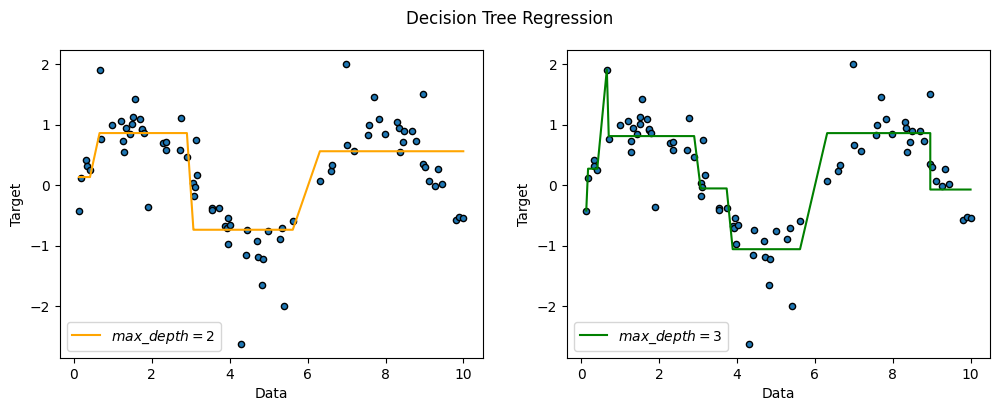

In [131]:
plot_regression_models(X, y, preds[0], preds[1], np.array([2, 3]))

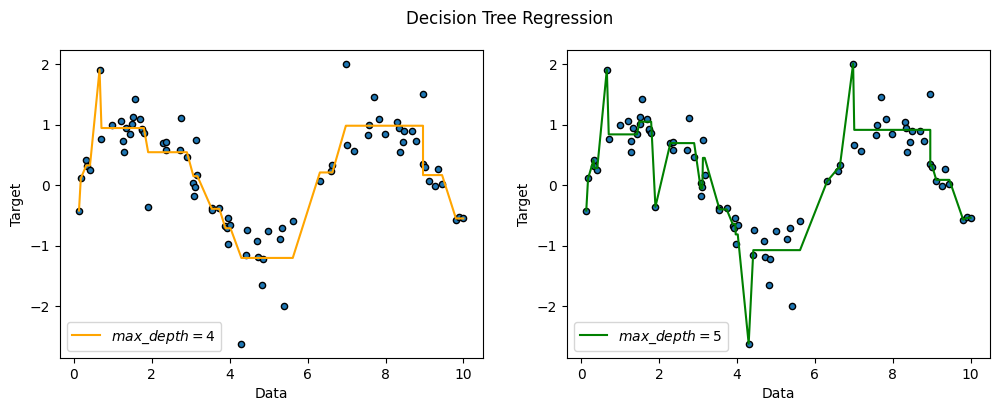

In [132]:
plot_regression_models(X, y, preds[2], preds[3], np.array([4, 5]))